# 🌲 Ensemble Models for HyperFaaS Resource Prediction

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import plot_tree
import yaml
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

sys.path.append('../../models/ensemble')
sys.path.append('../../src/models')

from tree_models import RandomForestModel, GradientBoostingModel

plt.style.use('seaborn-v0_8')
sns.set_palette("Set2")

## 📊 1. Data Preparation and Analysis

In [15]:
df = pd.read_csv('../../data/processed/training.csv')

feature_columns = [
    'hyperfaas-thumbnailer-json:latest_active_calls',
    'hyperfaas-bfs-json:latest_active_calls', 
    'hyperfaas-echo:latest_active_calls'
]
target_columns = ['cpu_usage', 'memory_usage']

# Create additional features for tree models
df_features = df[feature_columns].copy()

# Total active calls
df_features['total_active_calls'] = df_features.sum(axis=1)

# Call ratios (useful for tree splits)
df_features['thumbnailer_ratio'] = df_features[feature_columns[0]] / (df_features['total_active_calls'] + 1e-6)
df_features['bfs_ratio'] = df_features[feature_columns[1]] / (df_features['total_active_calls'] + 1e-6)
df_features['echo_ratio'] = df_features[feature_columns[2]] / (df_features['total_active_calls'] + 1e-6)

# Interaction features
df_features['thumbnailer_bfs_interaction'] = df_features[feature_columns[0]] * df_features[feature_columns[1]]
df_features['max_calls'] = df_features[feature_columns].max(axis=1)
df_features['min_calls'] = df_features[feature_columns].min(axis=1)
df_features['calls_std'] = df_features[feature_columns].std(axis=1)

# Binary features (activity indicators)
df_features['thumbnailer_active'] = (df_features[feature_columns[0]] > 0).astype(int)
df_features['bfs_active'] = (df_features[feature_columns[1]] > 0).astype(int)
df_features['echo_active'] = (df_features[feature_columns[2]] > 0).astype(int)
df_features['num_active_functions'] = df_features[['thumbnailer_active', 'bfs_active', 'echo_active']].sum(axis=1)

X = df_features.values
y = df[target_columns].values

# Handle missing values
X = np.nan_to_num(X, nan=0.0)
y = np.nan_to_num(y, nan=0.0)

# Update feature names
enhanced_feature_names = df_features.columns.tolist()

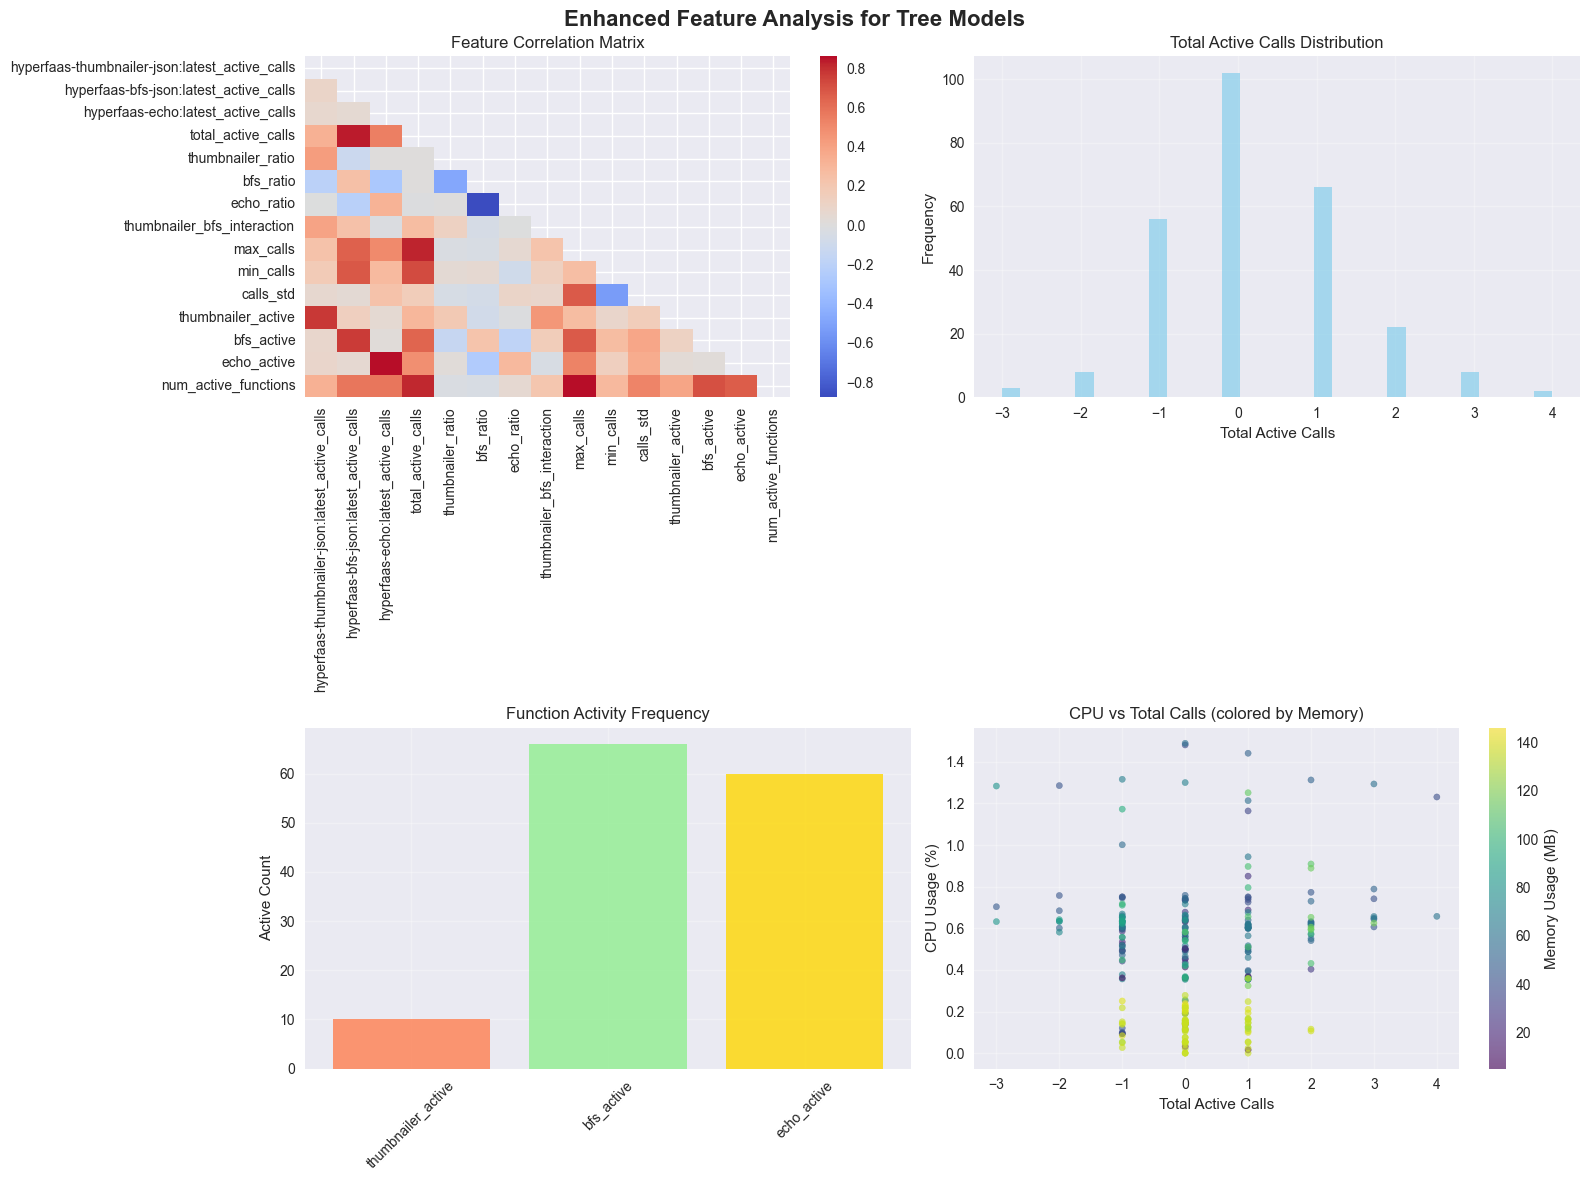

In [16]:
# Feature distribution and correlation analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Enhanced Feature Analysis for Tree Models', fontsize=16, fontweight='bold')

# Feature correlation heatmap
feature_df = pd.DataFrame(X, columns=enhanced_feature_names)
corr_matrix = feature_df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', center=0, ax=axes[0,0])
axes[0,0].set_title('Feature Correlation Matrix')

# Total calls distribution
axes[0,1].hist(feature_df['total_active_calls'], bins=30, alpha=0.7, color='skyblue')
axes[0,1].set_title('Total Active Calls Distribution')
axes[0,1].set_xlabel('Total Active Calls')
axes[0,1].set_ylabel('Frequency')
axes[0,1].grid(True, alpha=0.3)

# Function activity patterns
activity_data = feature_df[['thumbnailer_active', 'bfs_active', 'echo_active']]
activity_counts = activity_data.sum()
axes[1,0].bar(activity_counts.index, activity_counts.values, color=['coral', 'lightgreen', 'gold'], alpha=0.8)
axes[1,0].set_title('Function Activity Frequency')
axes[1,0].set_ylabel('Active Count')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(True, alpha=0.3)

# Resource usage vs total calls
scatter = axes[1,1].scatter(feature_df['total_active_calls'], y[:, 0], 
                          c=y[:, 1], cmap='viridis', alpha=0.6, s=20)
axes[1,1].set_title('CPU vs Total Calls (colored by Memory)')
axes[1,1].set_xlabel('Total Active Calls')
axes[1,1].set_ylabel('CPU Usage (%)')
plt.colorbar(scatter, ax=axes[1,1], label='Memory Usage (MB)')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
# Split the data (tree models don't require scaling)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

## 🌲 2. Train Ensemble Models

In [18]:
model_configs = {
    'random_forest': {
        'type': 'ensemble',
        'hyperparameters': {
            'n_estimators': 100,
            'max_depth': 10,
            'min_samples_split': 5,
            'min_samples_leaf': 2,
            'max_features': 'sqrt',
            'random_state': 42
        }
    },
    'gradient_boosting': {
        'type': 'ensemble',
        'hyperparameters': {
            'n_estimators': 100,
            'max_depth': 6,
            'learning_rate': 0.1,
            'subsample': 0.8,
            'min_samples_split': 5,
            'min_samples_leaf': 2,
            'random_state': 42
        }
    }
}

model_classes = {
    'random_forest': RandomForestModel,
    'gradient_boosting': GradientBoostingModel
}

In [19]:
trained_models = {}
training_results = {}

for model_name, config in model_configs.items():
    print(f"\n🏋️ Training {model_name.replace('_', ' ').title()}...")
    
    model = model_classes[model_name](config)
    model.feature_names = enhanced_feature_names
    model.target_names = target_columns
    
    history = model.train(X_train, y_train, X_val, y_val)
    
    test_metrics = model.evaluate(X_test, y_test)
    test_predictions = model.predict(X_test)
    
    trained_models[model_name] = model
    training_results[model_name] = {
        'history': history,
        'test_metrics': test_metrics,
        'predictions': test_predictions
    }
    
    print(f"  ✓ Test R²: {test_metrics.get('r2_total', 0):.4f}")
    print(f"  ✓ Test MSE: {test_metrics.get('mse_total', 0):.4f}")


🏋️ Training Random Forest...
  ✓ Test R²: 0.0598
  ✓ Test MSE: 728.2981

🏋️ Training Gradient Boosting...
  ✓ Test R²: 0.0938
  ✓ Test MSE: 659.3045


## 🌳 3. Model Behavior Analysis

🏆 Ensemble Model Performance Comparison:
            Model  R² Total  MSE Total  R² CPU  R² Memory  MAE Total    MAPE Total
Gradient Boosting    0.0938   659.3045  0.0338     0.1537    14.3580 35893979.3000
    Random Forest    0.0598   728.2981  0.0543     0.0652    16.2642 35933353.3492


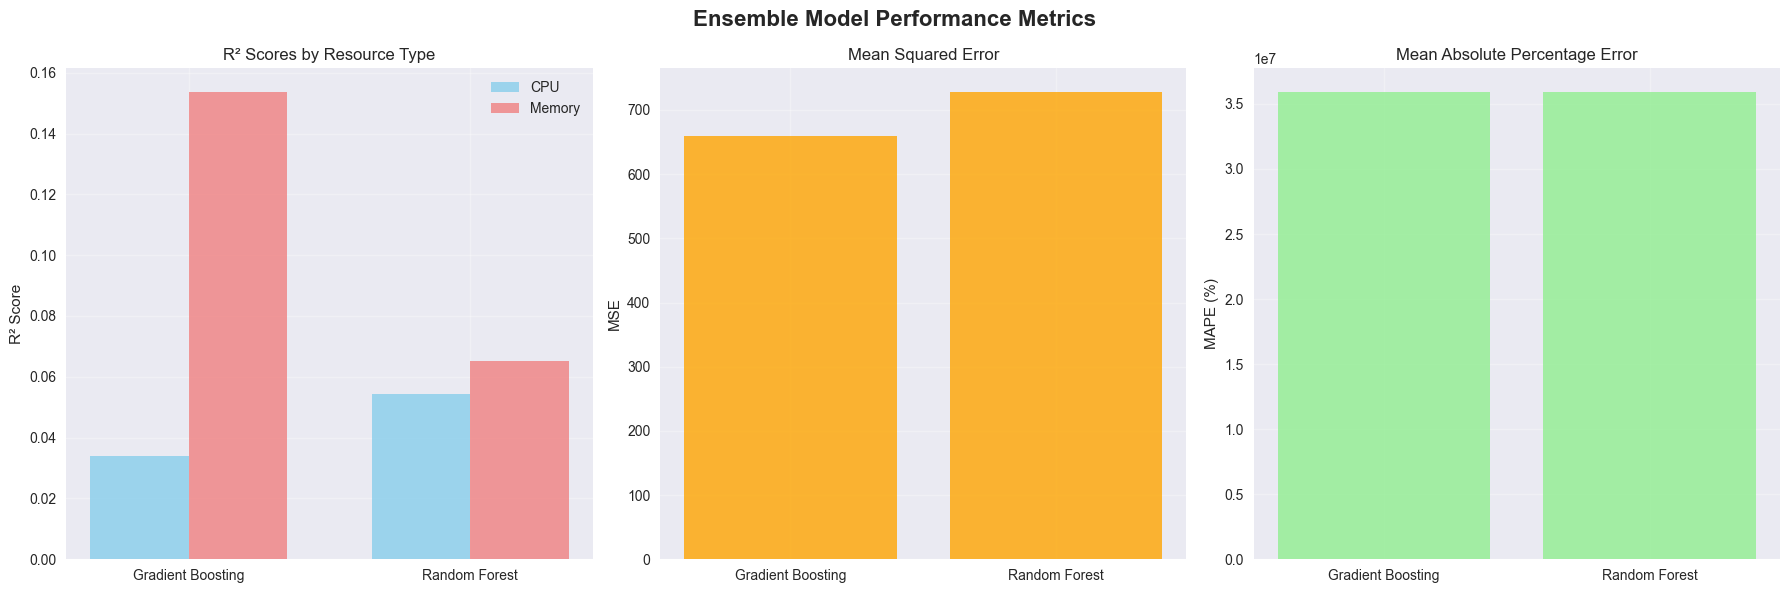

In [20]:
# Model performance comparison
comparison_data = []
for model_name, results in training_results.items():
    metrics = results['test_metrics']
    comparison_data.append({
        'Model': model_name.replace('_', ' ').title(),
        'R² Total': metrics.get('r2_total', 0),
        'MSE Total': metrics.get('mse_total', 0),
        'R² CPU': metrics.get('r2_cpu', 0),
        'R² Memory': metrics.get('r2_memory', 0),
        'MAE Total': metrics.get('mae_total', 0),
        'MAPE Total': metrics.get('mape_total', 0)
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('R² Total', ascending=False)

print("🏆 Ensemble Model Performance Comparison:")
print("=" * 80)
print(comparison_df.to_string(index=False, float_format='%.4f'))

# Performance visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Ensemble Model Performance Metrics', fontsize=16, fontweight='bold')

# R² scores
x = np.arange(len(comparison_df))
width = 0.35
axes[0].bar(x - width/2, comparison_df['R² CPU'], width, label='CPU', alpha=0.8, color='skyblue')
axes[0].bar(x + width/2, comparison_df['R² Memory'], width, label='Memory', alpha=0.8, color='lightcoral')
axes[0].set_title('R² Scores by Resource Type')
axes[0].set_ylabel('R² Score')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison_df['Model'])
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MSE comparison
axes[1].bar(comparison_df['Model'], comparison_df['MSE Total'], color='orange', alpha=0.8)
axes[1].set_title('Mean Squared Error')
axes[1].set_ylabel('MSE')
axes[1].grid(True, alpha=0.3)

# MAPE comparison
axes[2].bar(comparison_df['Model'], comparison_df['MAPE Total'], color='lightgreen', alpha=0.8)
axes[2].set_title('Mean Absolute Percentage Error')
axes[2].set_ylabel('MAPE (%)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 🎯 5. Prediction Visualizations

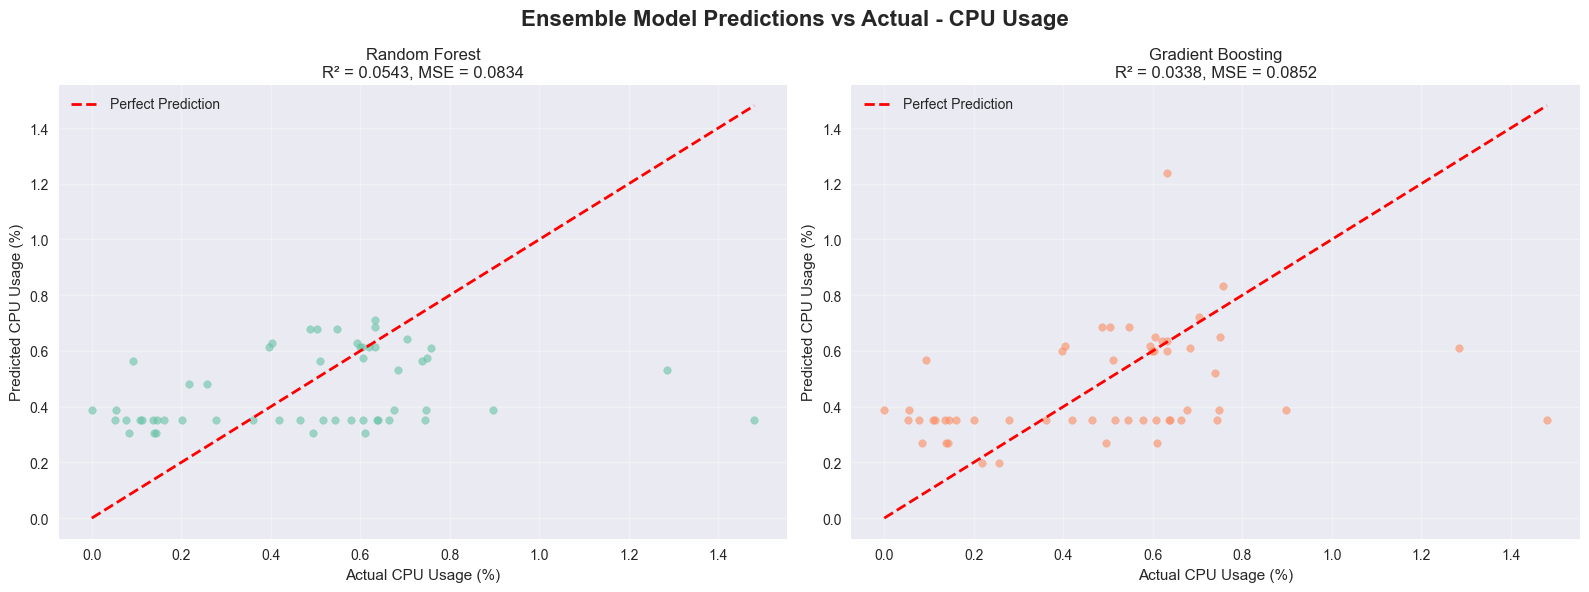

In [21]:
# CPU predictions vs actual
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Ensemble Model Predictions vs Actual - CPU Usage', fontsize=16, fontweight='bold')

model_names = list(training_results.keys())
for i, model_name in enumerate(model_names):
    predictions = training_results[model_name]['predictions']
    actual_cpu = y_test[:, 0]
    predicted_cpu = predictions[:, 0]
    
    # Scatter plot
    axes[i].scatter(actual_cpu, predicted_cpu, alpha=0.6, s=30, color=f'C{i}')
    
    # Perfect prediction line
    min_val = min(actual_cpu.min(), predicted_cpu.min())
    max_val = max(actual_cpu.max(), predicted_cpu.max())
    axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    # Calculate metrics
    r2 = training_results[model_name]['test_metrics'].get('r2_cpu', 0)
    mse = mean_squared_error(actual_cpu, predicted_cpu)
    
    axes[i].set_title(f'{model_name.replace("_", " ").title()}\nR² = {r2:.4f}, MSE = {mse:.4f}')
    axes[i].set_xlabel('Actual CPU Usage (%)')
    axes[i].set_ylabel('Predicted CPU Usage (%)')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

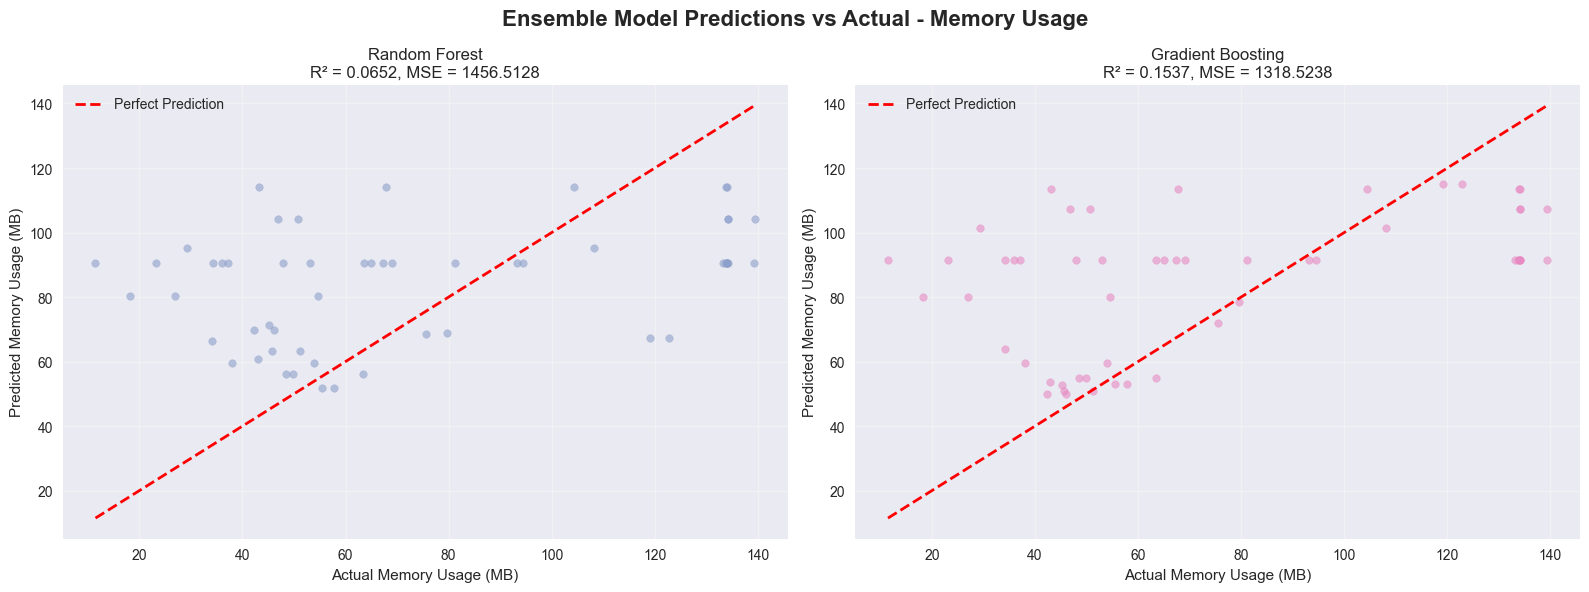

In [22]:
# Memory predictions vs actual
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Ensemble Model Predictions vs Actual - Memory Usage', fontsize=16, fontweight='bold')

for i, model_name in enumerate(model_names):
    predictions = training_results[model_name]['predictions']
    actual_memory = y_test[:, 1]
    predicted_memory = predictions[:, 1]
    
    # Scatter plot
    axes[i].scatter(actual_memory, predicted_memory, alpha=0.6, s=30, color=f'C{i+2}')
    
    # Perfect prediction line
    min_val = min(actual_memory.min(), predicted_memory.min())
    max_val = max(actual_memory.max(), predicted_memory.max())
    axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    # Calculate metrics
    r2 = training_results[model_name]['test_metrics'].get('r2_memory', 0)
    mse = mean_squared_error(actual_memory, predicted_memory)
    
    axes[i].set_title(f'{model_name.replace("_", " ").title()}\nR² = {r2:.4f}, MSE = {mse:.4f}')
    axes[i].set_xlabel('Actual Memory Usage (MB)')
    axes[i].set_ylabel('Predicted Memory Usage (MB)')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 📊 4. Outlier and Robustness Analysis

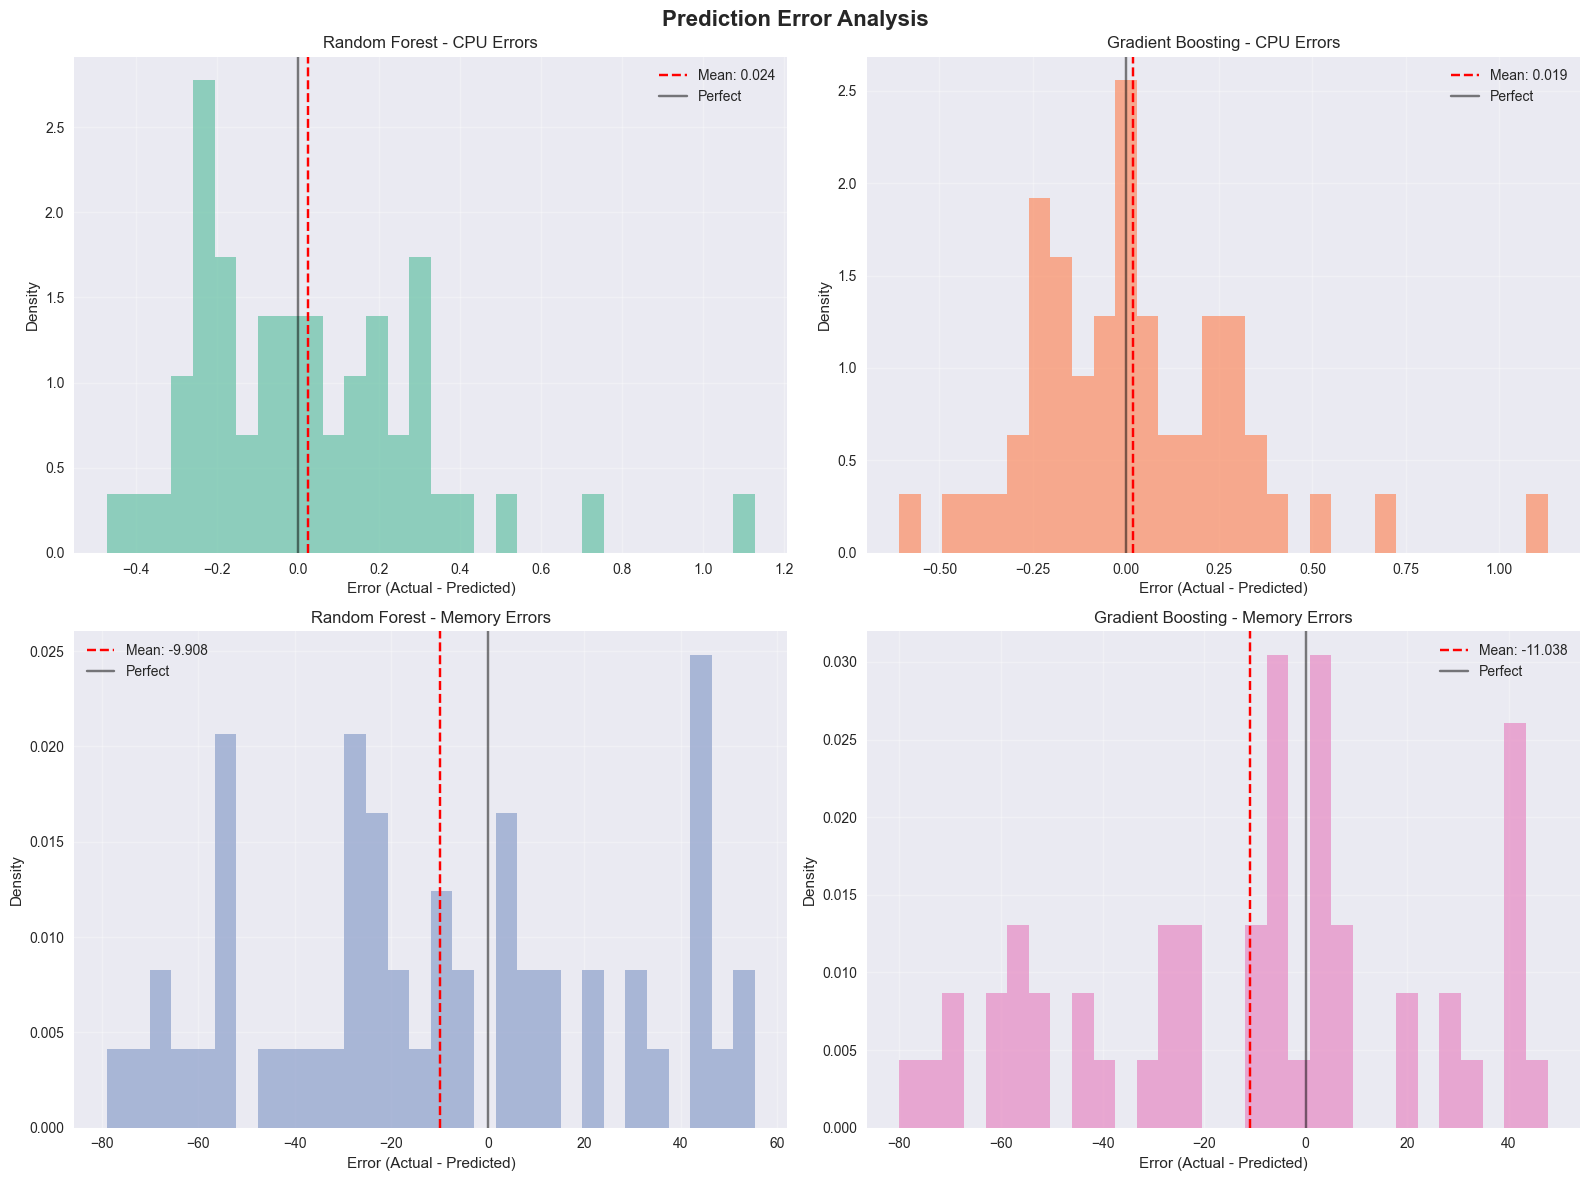

📊 Prediction Error Statistics:

🌲 Random Forest:
  CPU - Mean Error: 0.0243, Std: 0.2878
  Memory - Mean Error: -9.9081, Std: 36.8557
  Outliers - CPU: 2/54 (3.7%)
  Outliers - Memory: 1/54 (1.9%)

🌲 Gradient Boosting:
  CPU - Mean Error: 0.0193, Std: 0.2913
  Memory - Mean Error: -11.0383, Std: 34.5931
  Outliers - CPU: 3/54 (5.6%)
  Outliers - Memory: 3/54 (5.6%)


In [23]:
# Analyze prediction errors and outliers
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Prediction Error Analysis', fontsize=16, fontweight='bold')

for i, model_name in enumerate(model_names):
    predictions = training_results[model_name]['predictions']
    
    # CPU errors
    cpu_errors = y_test[:, 0] - predictions[:, 0]
    axes[0, i].hist(cpu_errors, bins=30, alpha=0.7, color=f'C{i}', density=True)
    axes[0, i].axvline(cpu_errors.mean(), color='red', linestyle='--', label=f'Mean: {cpu_errors.mean():.3f}')
    axes[0, i].axvline(0, color='black', linestyle='-', alpha=0.5, label='Perfect')
    axes[0, i].set_title(f'{model_name.replace("_", " ").title()} - CPU Errors')
    axes[0, i].set_xlabel('Error (Actual - Predicted)')
    axes[0, i].set_ylabel('Density')
    axes[0, i].legend()
    axes[0, i].grid(True, alpha=0.3)
    
    # Memory errors
    memory_errors = y_test[:, 1] - predictions[:, 1]
    axes[1, i].hist(memory_errors, bins=30, alpha=0.7, color=f'C{i+2}', density=True)
    axes[1, i].axvline(memory_errors.mean(), color='red', linestyle='--', label=f'Mean: {memory_errors.mean():.3f}')
    axes[1, i].axvline(0, color='black', linestyle='-', alpha=0.5, label='Perfect')
    axes[1, i].set_title(f'{model_name.replace("_", " ").title()} - Memory Errors')
    axes[1, i].set_xlabel('Error (Actual - Predicted)')
    axes[1, i].set_ylabel('Density')
    axes[1, i].legend()
    axes[1, i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Error statistics
print("📊 Prediction Error Statistics:")
print("=" * 60)
for model_name in model_names:
    predictions = training_results[model_name]['predictions']
    cpu_errors = y_test[:, 0] - predictions[:, 0]
    memory_errors = y_test[:, 1] - predictions[:, 1]
    
    print(f"\n🌲 {model_name.replace('_', ' ').title()}:")
    print(f"  CPU - Mean Error: {cpu_errors.mean():.4f}, Std: {cpu_errors.std():.4f}")
    print(f"  Memory - Mean Error: {memory_errors.mean():.4f}, Std: {memory_errors.std():.4f}")
    
    # Outlier detection (errors > 2 standard deviations)
    cpu_outliers = np.abs(cpu_errors) > 2 * cpu_errors.std()
    memory_outliers = np.abs(memory_errors) > 2 * memory_errors.std()
    
    print(f"  Outliers - CPU: {cpu_outliers.sum()}/{len(cpu_errors)} ({100*cpu_outliers.mean():.1f}%)")
    print(f"  Outliers - Memory: {memory_outliers.sum()}/{len(memory_errors)} ({100*memory_outliers.mean():.1f}%)")

## 🎯 5. Ensemble-Specific Insights

🌲 Random Forest Analysis:
  Number of Trees: 100
  Average Tree Depth: 5.8
  Max Tree Depth: 8
  Min Tree Depth: 4


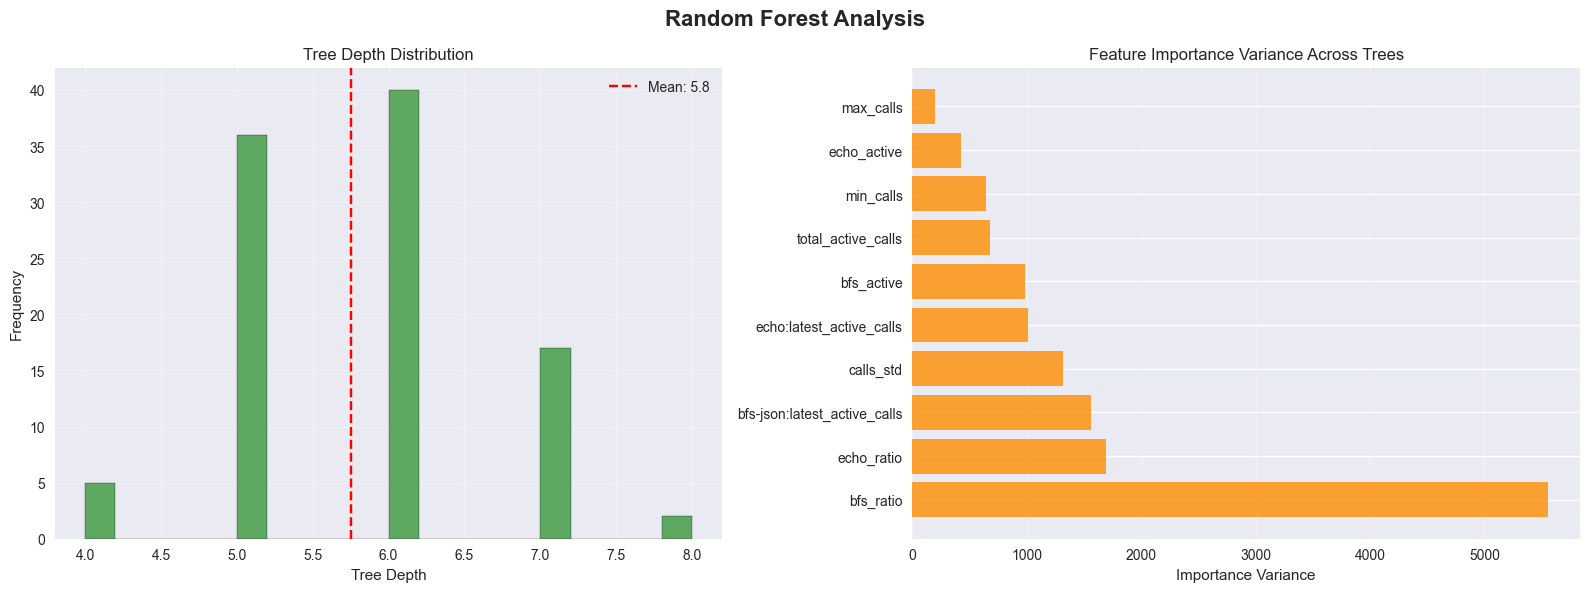

In [24]:
# Random Forest specific analysis
rf_model = trained_models['random_forest']
if hasattr(rf_model.model, 'estimators_'):
    n_trees = len(rf_model.model.estimators_)
    tree_depths = [tree.tree_.max_depth for tree in rf_model.model.estimators_]
    
    print("🌲 Random Forest Analysis:")
    print(f"  Number of Trees: {n_trees}")
    print(f"  Average Tree Depth: {np.mean(tree_depths):.1f}")
    print(f"  Max Tree Depth: {np.max(tree_depths)}")
    print(f"  Min Tree Depth: {np.min(tree_depths)}")
    
    # Tree depth distribution
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Random Forest Analysis', fontsize=16, fontweight='bold')
    
    axes[0].hist(tree_depths, bins=20, alpha=0.7, color='forestgreen', edgecolor='black')
    axes[0].axvline(np.mean(tree_depths), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(tree_depths):.1f}')
    axes[0].set_title('Tree Depth Distribution')
    axes[0].set_xlabel('Tree Depth')
    axes[0].set_ylabel('Frequency')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Feature importance across trees (variance)
    feature_importance_vars = []
    for i in range(len(enhanced_feature_names)):
        tree_importances = [tree.tree_.compute_feature_importances(normalize=False)[i] 
                          if i < len(tree.tree_.compute_feature_importances(normalize=False)) else 0
                          for tree in rf_model.model.estimators_]
        feature_importance_vars.append(np.var(tree_importances))
    
    # Plot top varying features
    top_varying_indices = np.argsort(feature_importance_vars)[::-1][:10]
    top_varying_features = [enhanced_feature_names[i] for i in top_varying_indices]
    top_varying_vars = [feature_importance_vars[i] for i in top_varying_indices]
    
    axes[1].barh(range(len(top_varying_features)), top_varying_vars, 
                color='darkorange', alpha=0.8)
    axes[1].set_yticks(range(len(top_varying_features)))
    axes[1].set_yticklabels([f.replace('hyperfaas-', '') for f in top_varying_features])
    axes[1].set_title('Feature Importance Variance Across Trees')
    axes[1].set_xlabel('Importance Variance')
    axes[1].grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()

# Gradient Boosting specific analysis
gb_model = trained_models['gradient_boosting']
if hasattr(gb_model.model, 'estimators_'):
    n_estimators = len(gb_model.model.estimators_)
    learning_rate = gb_model.config['hyperparameters']['learning_rate']
    
    print(f"\n🚀 Gradient Boosting Analysis:")
    print(f"  Number of Estimators: {n_estimators}")
    print(f"  Learning Rate: {learning_rate}")
    print(f"  Sequential Learning: Each tree corrects previous errors")
    print(f"  Feature Selection: Automatic through gradient optimization")